In [1]:
import scipy.io
import numpy as np 
import pdb
import torch
from common.data_normalization import *
from common.pt_build_model import *
import matplotlib.pyplot as plt
import glob,pickle,os,copy,sys,random
from sys import argv
from process_params import *
# argv lr heldout nntype seed dropout nodes epoch nm ne suffix(avi_, avi_v1_, ...) combined_train

seed=0
nn_type = '2'
held_out = .1
lr = .0001
dropout_rate = .1
nodes=200
ep=30
dm='wm'
train_mode='ne'
suffix='avi_'
combined_train=True
if len(argv)>3:
    lr=float(argv[1])
    held_out=float(argv[2])
    nn_type=argv[3]
    seed=int(argv[4])
    dropout_rate=float(argv[5])
    nodes=int(argv[6])
    ep=int(argv[7])
    if len(argv)>8:
        dm=argv[8]
        train_mode=argv[9]
        suffix=argv[10]
        combined_train=argv[11]
data_mode=data_mode[:-2]+dm
if train_separate:
    train_ds_path=base_path+color+'_data/'+obj+'/train_separate_'+data_type+data_mode+'_'+suffix+'f'
    test_ds_path=base_path+color+'_data/'+obj+'/test/test_separate_'+data_type+data_mode+'_'+suffix+'f'
#Assume episodes are always separated
else:
    raise    

with open(test_ds_path, 'rb') as pickle_file:
     test_ds_ls,test_ds_all_ls,state_dim,action_dim,test_traj_gt_ls,real_test_actions_ls = pickle.load(pickle_file)
with open(train_ds_path, 'rb') as pickle_file:
     train_ds_ls,train_ds_all_ls,state_dim,action_dim,train_traj_gt_ls,real_train_actions_ls = pickle.load(pickle_file)
task_ofs = state_dim + action_dim

if combined_train:
    test_ds_all_ls+=train_ds_all_ls
    real_test_actions_ls+=real_train_actions_ls
    test_ds_ls+=train_ds_ls
    test_traj_gt_ls+=train_traj_gt_ls

test_ds_all = [torch.tensor(data, dtype=dtype) for data in test_ds_all_ls]
real_test_actions=[torch.tensor(ac, dtype=dtype) for ac in real_test_actions_ls]
test_eps_len=[ep.shape[0] for ep in test_ds_ls]

print("Rolling out " + str(len(test_ds_ls)) + "test trajectories.")

cuda = False
dtype = torch.float
#save_path = 'save_model/'
#pred_path = 'avi_pred_fig/'
save_path = dm+'_'+train_mode+'_'+suffix+'save_model_f/'
pred_path = dm+'_'+train_mode+'_'+suffix+'pred_fig_f/'
if not os.path.exists(pred_path):
    os.makedirs(pred_path)
model_save_path = save_path + 'model_lr' + str(lr)+ '_' +'val' + str(held_out)+ '_' + 'seed' + str(seed) + '_nn_' + nn_type + '_dp_' + str(dropout_rate)+'_nodes_'+str(nodes) 
model_save_path += '_epochs_'+str(ep)
pred_fig_path = pred_path + 'traj_lr' + str(lr)+ '_' +'val' + str(held_out)+ '_' + 'seed' + str(seed) + '_nn_' + nn_type + '_dp_' + str(dropout_rate)+'_nodes_'+str(nodes)

Rolling out 465test trajectories.


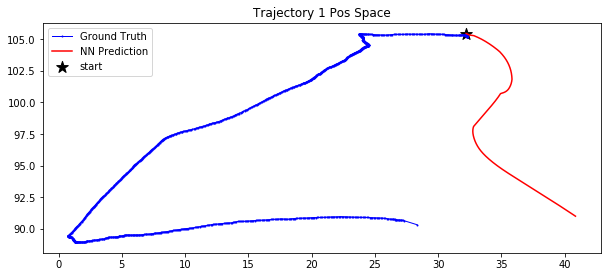

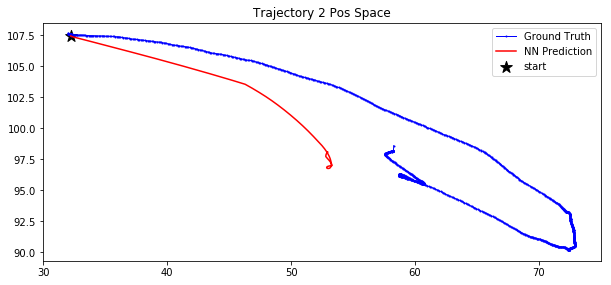

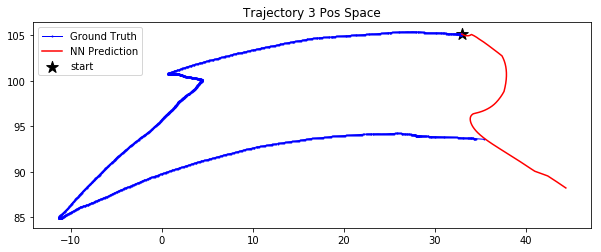

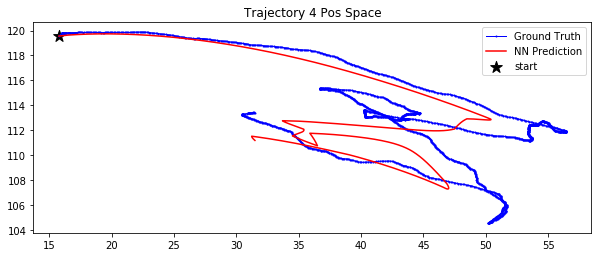

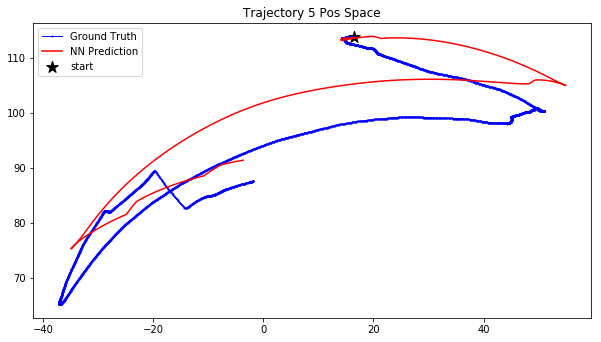

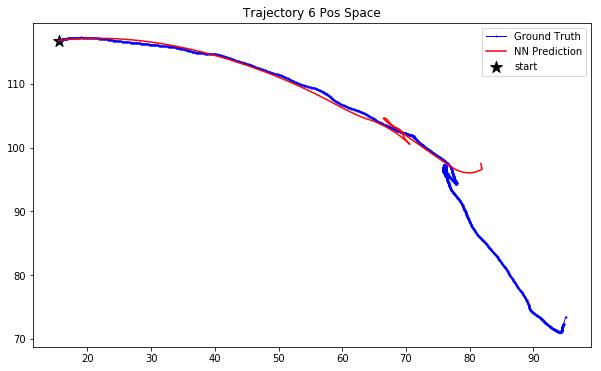

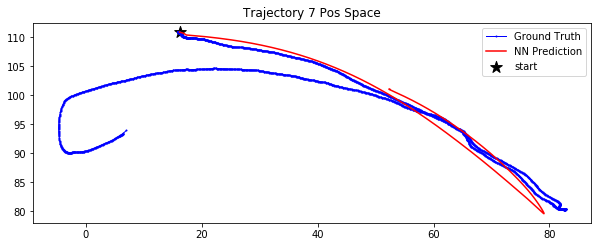

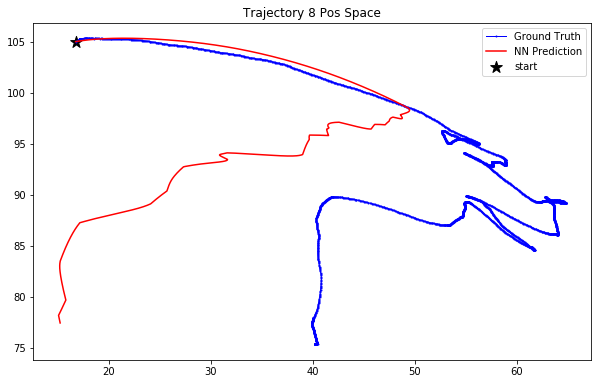

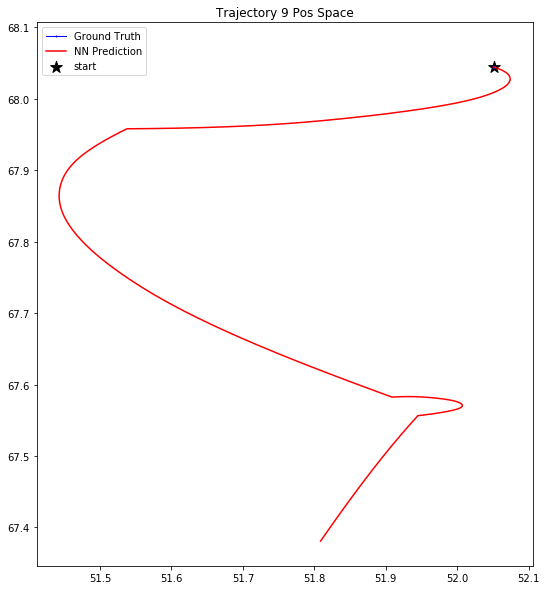

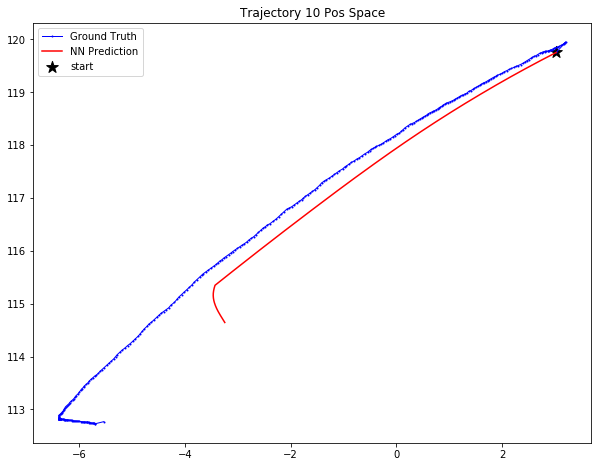

In [2]:
with open(model_save_path, 'rb') as pickle_file:
    model = torch.load(pickle_file, map_location='cpu')
if cuda: 
    model = model.to('cuda')
    model.norm = tuple(n.cuda() for n in model.norm)

torch.manual_seed(seed)
model.eval()
#for i in range(len(test_ds_ls)):
for i in range(0,10):
    gt_states = test_ds_all[i][:,:state_dim]
    real_actions = real_test_actions[i]
    valid_states_for_plot = np.vstack(test_traj_gt_ls[i])
    valid_states_for_plot = torch.tensor(valid_states_for_plot, dtype=dtype)
    if cuda:
        gt_states = gt_states.cuda()
        valid_states_for_plot = valid_states_for_plot.cuda()
        model = model.to('cuda')
        model.norm = tuple([n.cuda() for n in model.norm])
    with torch.no_grad():
        pred_states = model.run_traj(gt_states,real_actions)

    fig = plt.figure()
    plt.scatter(valid_states_for_plot[0, 0], valid_states_for_plot[0, 1], s=150, c='k', marker="*",label='start')
    plt.plot(valid_states_for_plot[:, 0], valid_states_for_plot[:, 1], color='blue', label='Ground Truth', marker='.', markersize=2, linewidth=1)
    plt.plot(pred_states[:, 0], pred_states[:, 1], color='red', label='NN Prediction')
    plt.axis('scaled')
    plt.title('Trajectory '+str(i+1)+ ' Pos Space')
    plt.legend()
    fig_loc=pred_fig_path +'_traj_'+str(i+1)+'_pos.png'
    if len(argv)>6:
        fig_loc=pred_fig_path +'_traj_'+str(i+1)+'_epoch_'+str(ep)+'_pos.png'
    fig.set_size_inches(10, 10)
    plt.show()
    fig.savefig(fig_loc)

(2245, 6)